# Capstone Project -- Creating An REIT Portfolio

## I. Introduction

   The overarching goal of this capstone project is to create a publicly traded REIT (Real Estate Investment Trust) portfolio in Austin, Texas, USA. Specifically an REIT gathers funding from investors and invests it in income-generating real estate such as shopping malls, hotels, hospitals, and etc. The interest in Austin comes from the popular idea that Austin will become the new Silicon Valley. This movement of industry gives a good guarantee of public spending in Austin, TX which will be good for the real estate business. The precise goal of this project then is to pick **where to invest and what property types to invest in**.
       
   Parties interested in this project are those companies interested in creating an REIT or even those who already have created an REIT in Austin, to take advantage of the shift in location of the technology industry. 

## II.Data

   The data to be studied is that of neighborhood location, big tech location, population size and population growth, and lastly venue types.
   
   For the list of neighborhood names in Austin, data was obtained from the building and development webpage of the official [data.austintexas.gov](https://data.austintexas.gov/Building-and-Development/Neighborhoods/a7ap-j2yt). The data set version used is from the April 15, 2021 update.
   
   The list of Big Tech and Tech companies found in Austin were web scrapped with respect to the list found on the [Silicon Hills](https://en.wikipedia.org/wiki/Silicon_Hills) Wikipedia page.
   
   Location data (Latitude and Longitude) for neighborhoods and Tech companies were found using Nominatim with geopy. Data was from [OSM(open street map) data](https://www.openstreetmap.org/#map=4/38.01/-95.84).
   
   Population size and population growth were based on zip code location from data sets from [Kaggle](https://www.kaggle.com/census/us-population-by-zip-code). Specifically decennial data in the year 2000 and 2010 conducted by the U.S. Census Bureau for all of the U.S.A. by zip code.
   
   Venue data will be used as features to see if there are any underlying trends between the locations picked. [Foursquare API](https://developer.foursquare.com/) was used to retrieve these venue data.

## III.Methodology

   The stepwise order that was taken:
   
   First, the neighborhood data and big tech data were cleaned and processed. Their latitude and longitude data were gathered via Nominatim and stored as a pd.DataFrame. Their zip codes were also added.
   
   Second, the neighborhood and big tech location were visualized via Folium to see which neighborhoods were in the vicinity of these companies. It was also visualized to find out which neighborhoods had a higher density proximity to companies. These neighborhood zipcodes were then chosen to be processed later.
   
   Third, population and population growth data were gathered from decennial data and cleaned. The decennial data was for all of the U.S. and in order to figure out which were in Austin, Texas--the zip code of the neighborhoods were used as a filter. Additionally, since the data was split by age and gender, population data was combined per zip code.
   
   Fourth, population and population growth were then plotted via Matplotlib and the zip codes from neighborhoods in the top 5 population size and top 5 population growth (from 2000 to 2010). The zip codes chosen were not necessarily the largest but the ones that had a good cross-section between population size and population growth.
   
   Fifth, the zip codes that were chosen, namely, those near big tech, those with high population size and those with a strong population growth were used to find their respective neighborhoods. Foursquare API was then used to find the venues data surrounding these neighborhoods.
   
   Sixth, these venues were used as features to find out if there were any underlying trends between neighborhoods using K-Mean Clustering. (Unfortunately, it seems there was minimal, in the Discussion Area).
   
   Lastly, the frequency of venue types were found which were most common in these neighborhoods to create recommendations for which real estate types should be part of the REIT portfolio.

Preliminary step of package downloads:

In [1]:
#for data and dataframe handling
import numpy as np
import pandas as pd
#for geo-location retrieving
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
#for API handling
import requests
import json
from pandas.io.json import json_normalize
#for K-Means Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
#for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print("Done.")

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Done.


**1. Preparing Austin, TX neighborhood data:**

In [2]:
#import raw data
neighs=pd.read_csv("Neighborhoods.csv")
neighs.head()

,the_geom,FID,TARGET_FID,NEIGHNAME,SqMiles,Shape_Leng,Shape__Area,Shape__Length
0,MULTIPOLYGON (((-97.792307359674 30.4567073495...,3,3,ANDERSON MILL,8.669086,154458.205390,2.416802e+08,154458.205390
1,MULTIPOLYGON (((-97.670762852964 30.3085399639...,95,95,WINDSOR PARK,2.383074,40527.378654,6.643628e+07,40527.378654
2,MULTIPOLYGON (((-97.753526659646 30.2387648363...,19,19,DAWSON,0.495535,17697.924998,1.381473e+07,17697.924998
3,MULTIPOLYGON (((-97.738154269236 30.3027463827...,91,91,WEST UNIVERSITY,0.738442,24981.044476,2.058658e+07,24981.044476
4,MULTIPOLYGON (((-97.682624533084 30.2858668623...,49,49,MLK,1.545283,33470.415430,4.308001e+07,33470.415430


In [3]:
#Extract names
just_the_neighs=neighs["NEIGHNAME"]
#create DataFrame with empty lat. and long. columns
starter_dict={"Neighborhood":just_the_neighs,"Latitude":"","Longitude":""}
austin_df=pd.DataFrame(starter_dict)
#Later, nominatim requires more specification for neighborhoods
austin_df["Neighborhood"]=austin_df["Neighborhood"]+", Austin, TX, USA"
austin_df.head()

,Neighborhood,Latitude,Longitude
0,"ANDERSON MILL, Austin, TX, USA",,
1,"WINDSOR PARK, Austin, TX, USA",,
2,"DAWSON, Austin, TX, USA",,
3,"WEST UNIVERSITY, Austin, TX, USA",,
4,"MLK, Austin, TX, USA",,


The OSM(Open Street Map) database didn't recognize some of the names in a certain format so they had to be renamed.

In [4]:
#rename for nominatim
rename_dict={9:"Pioneer Hill, Austin, TX, USA",
             32:"Dittmar Crossing, Austin, TX, USA",
             49:"Mueller, Austin, TX, USA",
             71:"Cherrywood, Austin, TX, USA",
             76:"North Lamar, Austin, TX, USa",
             83:"Avery Ranch, Austin, TX, USA",
             86:"Barton Creek, Austin, TX, USA",
             102:"Oak Hill, Austin, TX, USA"}
for key, value in rename_dict.items():
    austin_df["Neighborhood"][key]=value

Four of the neighborhoods, OSM did not recognize even with renaming. Two of those will later be added back as they were  found on google search. Although row 52 and 74 were not added back. Row 52 or Hays Wartha neighborhood was not recognized by either google maps engine search or OSM. Row 57 or Robinson ranch neighborhood, according to the google maps search engine, belongs to Williamson county and not Travis country (which is where Austin resides).

In [5]:
#drop indices that were not recognize in its database
drop_index=[52,55,57,74]
for i in drop_index:
    austin_df.drop(index=i, inplace=True)
austin_df.reset_index(drop=True, inplace=True)
austin_df.tail()

,Neighborhood,Latitude,Longitude
94,"SWEETBRIAR, Austin, TX, USA",,
95,"SPICEWOOD, Austin, TX, USA",,
96,"WINDSOR HILLS, Austin, TX, USA",,
97,"ROGERS HILL, Austin, TX, USA",,
98,"Oak Hill, Austin, TX, USA",,


In [6]:
#find geo-location data via nominatim
for i in range(0,len(austin_df["Neighborhood"])):
    geolocator=Nominatim(user_agent="Austin_locator")
    location=geolocator.geocode(austin_df["Neighborhood"][i])
    austin_df["Latitude"][i]=location.latitude
    austin_df["Longitude"][i]=location.longitude
austin_df.head()

,Neighborhood,Latitude,Longitude
0,"ANDERSON MILL, Austin, TX, USA",30.4558,-97.8071
1,"WINDSOR PARK, Austin, TX, USA",30.3135,-97.6911
2,"DAWSON, Austin, TX, USA",30.2329,-97.7614
3,"WEST UNIVERSITY, Austin, TX, USA",30.2852,-97.7339
4,"MLK, Austin, TX, USA",30.284,-97.694


A regular expression was used to search strings for the zip codes tied to them. Namely *(\d{5})*, meaning "any group of 5 digits".

In [7]:
#first extract the reference address
addresses=[]#empty list to append reference address used by Nominatim
for i in range(0,len(austin_df["Neighborhood"])):
    geoloc=Nominatim(user_agent="ZipTest")
    location=geoloc.geocode(austin_df["Neighborhood"][i])
    addresses.append(location.address)
#second extract zipcode using address
addresses_df=pd.DataFrame(addresses,columns=["address"])
addresses_df["Zip Code"]=addresses_df['address'].str.extract(r'(\d{5})')#any group of 5 digits
addresses_df.head()

,address,Zip Code
0,"Anderson Mill, Austin, Williamson County, Texa...",78750
1,"Windsor Park, Austin, Travis County, Texas, 78...",78723
2,"Dawson, Austin, Travis County, Texas, 78704-72...",78704
3,"University of Texas at Austin, 1, Austin, Trav...",78712
4,"MLK, Austin, Travis County, Texas, 78721, Unit...",78721


Some of the reference addresses used by the OSM database had missing zipcode (nan values), this was found manually via google search and added.

In [8]:
#adjust for missing zipcodes/nan values
missing_zip={9:78754, 21:78758, 41:78757, 44:78732, 64:78653, 66:78757, 82:78735, 97:78724}
for index in missing_zip:
    addresses_df["Zip Code"][index]=missing_zip[index]
#change the zip codes to int64 dtype
addresses_df=addresses_df.astype({"Zip Code":"int64"})
addresses_df.dtypes

address     object
Zip Code     int64
dtype: object

The neighborhood zipcode and location data was now joined into one pd.DataFrame.

In [9]:
#join Zipcodes with Austin Neighborhoods 
del addresses_df["address"] #address column is no longer needed
austin_merged_df=austin_df.merge(addresses_df,left_index=True,right_index=True)#both values are align to the indices
austin_merged_df.head()

,Neighborhood,Latitude,Longitude,Zip Code
0,"ANDERSON MILL, Austin, TX, USA",30.4558,-97.8071,78750
1,"WINDSOR PARK, Austin, TX, USA",30.3135,-97.6911,78723
2,"DAWSON, Austin, TX, USA",30.2329,-97.7614,78704
3,"WEST UNIVERSITY, Austin, TX, USA",30.2852,-97.7339,78712
4,"MLK, Austin, TX, USA",30.284,-97.694,78721


Adding back neighborhoods that OSM did not recognize, but had location data from google searching.

In [10]:
add_back=pd.DataFrame(
    [["Village at Western Oaks, Austin, TX, USA", 30.2086, -97.8728, 78749],
    ["Whisper Valley, Austin, TX, USA", 30.292, -97.554, 78653]],
    columns=['Neighborhood', 'Latitude', 'Longitude', 'Zip Code'])
new_austin_df=austin_merged_df.append(add_back)
#re-index correctly
new_austin_df.reset_index(drop=True, inplace=True)
new_austin_df.tail()

,Neighborhood,Latitude,Longitude,Zip Code
96,"WINDSOR HILLS, Austin, TX, USA",30.3621,-97.6792,78753
97,"ROGERS HILL, Austin, TX, USA",30.2789,-97.6389,78724
98,"Oak Hill, Austin, TX, USA",30.3472,-97.7146,78757
99,"Village at Western Oaks, Austin, TX, USA",30.2086,-97.8728,78749
100,"Whisper Valley, Austin, TX, USA",30.292,-97.554,78653


**2. Prepare Big Tech location data**

In [11]:
#load big tech dataframe from webscrapping
big_tech_df=pd.read_csv("big_tech_austin.csv", index_col=0)
big_tech_df.head()

,Company,Address
0,AMD,"7171 Southwest Pkwy, Austin, TX 78735"
1,Adobe,"11501 Domain Drive, Austin, TX 78758"
2,Amazon,"11501 Alterra Pkwy, Austin, TX, 78758"
3,Applied Materials,"9700 US-290, Austin, TX 78724"
4,Arm Holdings,"5707 Southwest Parkway, Austin, TX 78735"


In [12]:
#create the columns for lat. and long.
big_tech_df["Latitude"]=""
big_tech_df["Longitude"]=""
#some of the addresses are not uptodate
#loop over the address and add their lat. and long. to the respective rows
for i in range(0,len(big_tech_df["Address"])):
    geolocator=Nominatim(user_agent="big_tech_locator")
    location=geolocator.geocode(big_tech_df["Address"][i])
    big_tech_df["Latitude"][i]=location.latitude
    big_tech_df["Longitude"][i]=location.longitude
big_tech_df.head()

,Company,Address,Latitude,Longitude
0,AMD,"7171 Southwest Pkwy, Austin, TX 78735",30.2516,-97.864
1,Adobe,"11501 Domain Drive, Austin, TX 78758",30.4015,-97.7236
2,Amazon,"11501 Alterra Pkwy, Austin, TX, 78758",30.4007,-97.7193
3,Applied Materials,"9700 US-290, Austin, TX 78724",30.335,-97.6145
4,Arm Holdings,"5707 Southwest Parkway, Austin, TX 78735",30.2451,-97.8435


**3. Plot Neighborhoods in Austin, Texas and Big Tech Locations**

The latitude and longitude of Austin, TX was found to be used as the maps center.

In [13]:
#austin centered location
austin_geo="Austin, Travis County, Texas"
austin_geolocator=Nominatim(user_agent="Austin_Centered")
austin_location=austin_geolocator.geocode(austin_geo)
austin_lat=location.latitude
austin_long=location.longitude
"The location of Austin, Texas is {} latitude and {} longitude.".format(austin_lat, austin_long)

'The location of Austin, Texas is 30.4270825 latitude and -97.74418837902884 longitude.'

In [14]:
#neighborhood maps in Austin, Texas
neigh_maps=folium.Map(location=[austin_lat, austin_long], zoom_start=10)
for lat, long, neigh, code in zip(new_austin_df["Latitude"],new_austin_df["Longitude"],new_austin_df["Neighborhood"],new_austin_df["Zip Code"]):
    label="{}, {}".format(neigh, code)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, long],
    radius=5,
    popup=label,
    color="#0017c4",
    fill=True,
    fill_color="#7ad7ff",
    fill_opacity=0.5,
    parse_html=False).add_to(neigh_maps)
#display neighborhoods
neigh_maps

In [15]:
#big tech companies in Austin, Texas
big_tech_maps=folium.Map(location=[austin_lat, austin_long], zoom_start=10)
for lat, long, company in zip(big_tech_df["Latitude"], big_tech_df["Longitude"], big_tech_df["Company"]):
    label="{}".format(company)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, long],
    radius=5,
    popup=label,
    color="#ffb300",
    fill=True,
    fill_color="#ffd470",
    fill_opacity=0.5,
    parse_html=False).add_to(big_tech_maps)
#display big tech locations
big_tech_maps

Most importantly, find the overlap of the neighborhoods and the big tech locations:

In [16]:
#neighborhood maps in Austin, Texas
overlap_maps=folium.Map(location=[austin_lat, austin_long], zoom_start=10)
for lat, long, neigh, code in zip(new_austin_df["Latitude"],new_austin_df["Longitude"],new_austin_df["Neighborhood"],new_austin_df["Zip Code"]):
    label="{}, {}".format(neigh, code)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, long],
    radius=5,
    popup=label,
    color="#0017c4",
    fill=True,
    fill_color="#7ad7ff",
    fill_opacity=0.1,
    parse_html=False).add_to(overlap_maps)
#overlap
for lat, long, company in zip(big_tech_df["Latitude"], big_tech_df["Longitude"], big_tech_df["Company"]):
    label="{}".format(company)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, long],
    radius=5,
    popup=label,
    color="#ffb300",
    fill=True,
    fill_color="#ffd470",
    fill_opacity=0.5,
    parse_html=False).add_to(overlap_maps)
#display neighborhoods
overlap_maps

From a closer visual inspection, ***zip code 78701 and 78759*** have a cluster of big tech companies near them the most. Specifically, at Downtown Austin 78701 and Gateway 78759.

**4. Factoring Population and Population Growth**

The location of Big Tech, doesn't necessarily mean that real estate is a good investment there. Population size and population growth is a good characteristic to look at when considering investment. i.e. The more people there are the higher the demand of land usage and ownership.

In [17]:
#load data of 2000 and 2010 population 
two_thousand=pd.read_csv("population_by_zip_2000.csv")
twenty10=pd.read_csv("population_by_zip_2010.csv")

In [18]:
two_thousand.head()

,minimum_age,maximum_age,gender,population,zipcode,geo_id
0,10.0,14.0,female,75,39769,8600000US39769
1,85.0,NaN,female,130,44047,8600000US44047
2,30.0,34.0,female,11,42436,8600000US42436
3,22.0,24.0,male,22,99685,8600000US99685
4,67.0,69.0,male,69,04239,8600000US04239


In [19]:
two_thousand.dtypes

minimum_age    float64
maximum_age    float64
gender          object
population       int64
zipcode         object
geo_id          object
dtype: object

Account for only the zip codes in the Austin, TX area. Then add those populations by zip code grouping.

In [20]:
#account for unique zip codes only since different places can have the same zip code
unique_zips=new_austin_df["Zip Code"].unique()
unique_zips.dtype

dtype('int64')

In [21]:
#extract population with respect to zipcode and sum those in the same zipcode together
z_dict={}
x=0
while x < (len(unique_zips)):
    #find the zip at the index and store it
    pos1=str(unique_zips[x])#the variable was stored as string in the original file
    #store the index position of matched zipcodes in the raw data
    a_list=two_thousand.index[two_thousand["zipcode"]==pos1].tolist() 
    b_list=[] #empty list to append population values of the indices
    for val in range(0,len(a_list)): #run through all the matched positions
        pos2=a_list[val] #extract index position
        b_list.append(two_thousand["population"][pos2]) #append the population
    z_dict[pos1]=sum(b_list) #store the zipcode-to-total population in the key_value pair
    x+=1
#create data frame
two_thousand_df=pd.DataFrame(list(z_dict.items()),columns=["Zip Code", "2000 Population"])
#convert to int64 dtype
two_thousand_df=two_thousand_df.astype({"Zip Code":"int64"})
two_thousand_df.head()

,Zip Code,2000 Population
0,78750,70428
1,78723,90330
2,78704,129747
3,78712,0
4,78721,30372


In [22]:
twenty10.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,50,30.0,34.0,female,61747,8600000US61747
1,5,85.0,NaN,male,64120,8600000US64120
2,1389,30.0,34.0,male,95117,8600000US95117
3,231,60.0,61.0,female,74074,8600000US74074
4,56,0.0,4.0,female,58042,8600000US58042


In [23]:
twenty10.dtypes

population       int64
minimum_age    float64
maximum_age    float64
gender          object
zipcode          int64
geo_id          object
dtype: object

Repeat the process for the 2010 population data. Meaning account only for Austin zip codes, and then sum the population  by zip code grouping.

In [24]:
#repeat steps for 2010 population data
h_dict={}
g=0
while g < (len(unique_zips)):
    pos3=unique_zips[g]#zipcode is no longer string obj so no need to convert to string
    m_list=twenty10.index[twenty10["zipcode"]==pos3].tolist() 
    n_list=[]
    for val in range(0,len(m_list)):
        pos4=m_list[val]
        n_list.append(twenty10["population"][pos4])
    h_dict[pos3]=sum(n_list)
    g+=1
twenty10_df=pd.DataFrame(list(h_dict.items()),columns=["Zip Code", "2010 Population"])
twenty10_df.head()

,Zip Code,2010 Population
0,78750,80442
1,78723,84990
2,78704,126351
3,78712,2580
4,78721,34275


Merge the two data sets into one for the Austin, TX area.

In [25]:
#combine decennial data with respect to Zip Code
decennial_pop_df=two_thousand_df.merge(twenty10_df,on="Zip Code",left_index=True,right_index=True)
decennial_pop_df.head()

,Zip Code,2000 Population,2010 Population
0,78750,70428,80442
1,78723,90330,84990
2,78704,129747,126351
3,78712,0,2580
4,78721,30372,34275


Find the difference between the 2010 and 2000 population to account for growth.

In [26]:
#find the growth between 2000 and 2010
decennial_pop_df["Population Change from 2000 to 2010"]=""#empty column to store the difference
for i in range(0,len(decennial_pop_df)):
    decennial_pop_df.iloc[i,3]=decennial_pop_df.iloc[i,2]-decennial_pop_df.iloc[i,1]
decennial_pop_df=decennial_pop_df.astype({"Population Change from 2000 to 2010":"int64"})

In [27]:
decennial_pop_df.head()

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
0,78750,70428,80442,10014
1,78723,90330,84990,-5340
2,78704,129747,126351,-3396
3,78712,0,2580,2580
4,78721,30372,34275,3903


**5. Graphing Population Size and Growth**

Pick the top five of population size and growth, and pick a zip code that is in good standing in both.

<function matplotlib.pyplot.show(*args, **kw)>

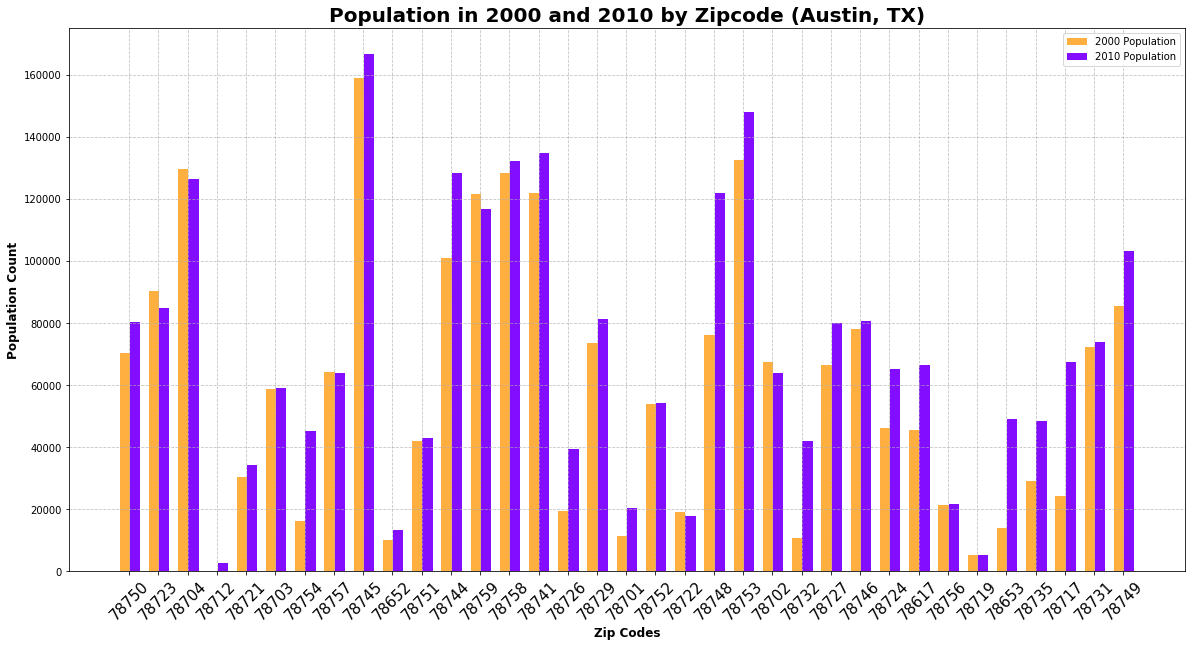

In [28]:
#plot population via grouped bar graph
N=len(decennial_pop_df)
ind=np.arange(N)
width=0.35
plt.figure(figsize=(20,10))
plt.grid(which="major", linestyle="--", alpha=0.75)
x_labels=list(decennial_pop_df["Zip Code"])
plt.bar(ind,decennial_pop_df["2000 Population"],width,label="2000 Population",color="#ffaf40")
plt.bar(ind+width,decennial_pop_df["2010 Population"],width,label="2010 Population",color="#820dff")
plt.xlabel("Zip Codes",fontsize=12, weight="bold")
plt.ylabel("Population Count",fontsize=12, weight="bold")
plt.title("Population in 2000 and 2010 by Zipcode (Austin, TX)",fontsize=20, weight="bold")
plt.xticks(ind+0.15,x_labels)
plt.xticks(fontsize=15, rotation=45)
plt.legend()
plt.show

Visual inspection shows zip codes: 78745, 78753, 78741, 78758, 78744 have the largest size in 2010. Verify:

In [29]:
decennial_pop_df.sort_values(by=["2010 Population"], ascending=False).head(10)

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
8,78745,159132,166842,7710
21,78753,132630,147903,15273
14,78741,121983,134805,12822
13,78758,128460,132216,3756
11,78744,101118,128460,27342
2,78704,129747,126351,-3396
20,78748,76083,121953,45870
12,78759,121641,116673,-4968
34,78749,85491,103347,17856
1,78723,90330,84990,-5340


<function matplotlib.pyplot.show(*args, **kw)>

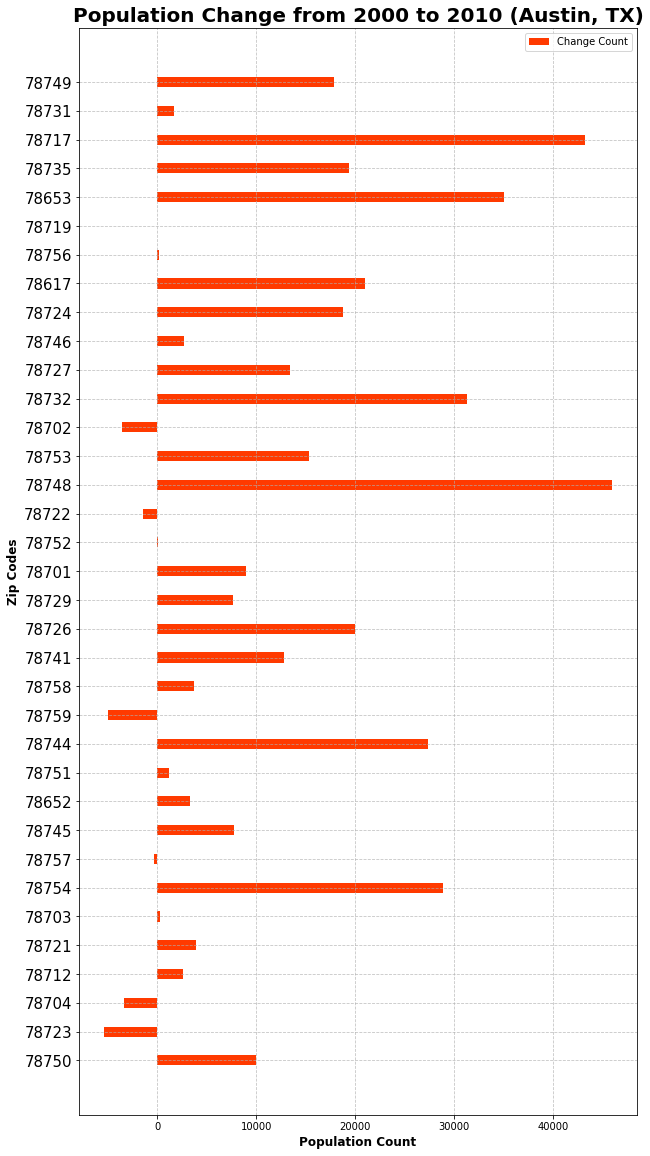

In [30]:
#plot population change
N=len(decennial_pop_df)
ind=np.arange(N)
width=0.35
plt.figure(figsize=(10,20))
plt.grid(which="major", linestyle="--", alpha=0.75)
c_labels=list(decennial_pop_df["Zip Code"])
plt.barh(ind,decennial_pop_df["Population Change from 2000 to 2010"],width,label="Change Count",color="#ff3a00")
plt.ylabel("Zip Codes",fontsize=12, weight="bold")
plt.xlabel("Population Count",fontsize=12, weight="bold")
plt.title("Population Change from 2000 to 2010 (Austin, TX)",fontsize=20, weight="bold")
plt.yticks(ind,c_labels)
plt.yticks(fontsize=15)
plt.legend()
plt.show

Visual inspection shows that the zip codes: 78748, 78717, 78653, 78732, 78754 had the most positive population growth. Verify.

In [31]:
decennial_pop_df.sort_values(by=["Population Change from 2000 to 2010"], ascending=False).head(10)

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
20,78748,76083,121953,45870
32,78717,24444,67614,43170
30,78653,14145,49125,34980
23,78732,10887,42180,31293
6,78754,16266,45108,28842
11,78744,101118,128460,27342
27,78617,45681,66630,20949
15,78726,19440,39366,19926
31,78735,29013,48393,19380
26,78724,46284,65088,18804


There are two zip codes chosen due to their good standing in the population size and population growth standing:

* ***78748 Rank 7th in Population Size and 1st in Growth***
* ***78744 Rank 5th in Population Size and 6th in Growth***

Inspect further, and compare to the zip codes near big tech companies (78701 and 78759):

In [32]:
decennial_pop_df[decennial_pop_df["Zip Code"]==78748]

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
20,78748,76083,121953,45870


In [33]:
decennial_pop_df[decennial_pop_df["Zip Code"]==78744]

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
11,78744,101118,128460,27342


In [34]:
decennial_pop_df[decennial_pop_df["Zip Code"]==78701]

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
17,78701,11565,20523,8958


In [35]:
decennial_pop_df[decennial_pop_df["Zip Code"]==78759]

,Zip Code,2000 Population,2010 Population,Population Change from 2000 to 2010
12,78759,121641,116673,-4968


***This overall shows where to invest. Specifically, in the four zip codes chosen.***

Afterwards, find the neighborhoods in the zip code 78748, 78744, 78701, 78759. The venues in these neighborhoods will be looked at to find what type of real estate should be part of investment portfolio.

In [36]:
#extract neighborhoods in this 78748 Zip Code
neighborhood_in_78748=[]
latitude_78748=[]
longitude_78748=[]
for i in range(0,len(austin_merged_df)):
    if austin_merged_df["Zip Code"][i]==78748:
        neighborhood_in_78748.append(austin_merged_df["Neighborhood"][i])
        latitude_78748.append(austin_merged_df["Latitude"][i])
        longitude_78748.append(austin_merged_df["Longitude"][i])
        print("{} neighborhood is in the 78748 zip code with latitude {} and longitude {}.".\
            format(austin_merged_df["Neighborhood"][i],austin_merged_df["Latitude"][i],austin_merged_df["Longitude"][i]))
#create 78748 dataframe
zip_78748_df=pd.DataFrame({"Neighborhood":neighborhood_in_78748,
                           "Latitude":latitude_78748,
                           "Longitude":longitude_78748})

Dittmar Crossing, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1837291 and longitude -97.8131157.
CHERRY CREEK, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1971128 and longitude -97.8248116.
SOUTH BRODIE, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1756216 and longitude -97.8516371.
SLAUGHTER CREEK, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1675537 and longitude -97.8483294.


In [37]:
#extract neighborhoods in this 78744 Zip Code
neighborhood_in_78744=[]
latitude_78744=[]
longitude_78744=[]
for i in range(0,len(austin_merged_df)):
    if austin_merged_df["Zip Code"][i]==78744:
        neighborhood_in_78744.append(austin_merged_df["Neighborhood"][i])
        latitude_78744.append(austin_merged_df["Latitude"][i])
        longitude_78744.append(austin_merged_df["Longitude"][i])
        print("{} neighborhood is in the 78748 zip code with latitude {} and longitude {}.".\
            format(austin_merged_df["Neighborhood"][i],austin_merged_df["Latitude"][i],austin_merged_df["Longitude"][i]))
#create 78744 dataframe
zip_78744_df=pd.DataFrame({"Neighborhood":neighborhood_in_78744,
                           "Latitude":latitude_78744,
                           "Longitude":longitude_78744})

MCKINNEY, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.2058765 and longitude -97.7280148.
BLUFF SPRINGS, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1787201 and longitude -97.7759286.
ONION CREEK, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1681165 and longitude -97.7448171.
FRANKLIN PARK, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.1968979 and longitude -97.7488002.


In [38]:
#extract neighborhoods in this 78701 Zip Code
neighborhood_in_78701=[]
latitude_78701=[]
longitude_78701=[]
for i in range(0,len(austin_merged_df)):
    if austin_merged_df["Zip Code"][i]==78701:
        neighborhood_in_78701.append(austin_merged_df["Neighborhood"][i])
        latitude_78701.append(austin_merged_df["Latitude"][i])
        longitude_78701.append(austin_merged_df["Longitude"][i])
        print("{} neighborhood is in the 78748 zip code with latitude {} and longitude {}.".\
            format(austin_merged_df["Neighborhood"][i],austin_merged_df["Latitude"][i],austin_merged_df["Longitude"][i]))
#create 78701 dataframe
zip_78701_df=pd.DataFrame({"Neighborhood":neighborhood_in_78701,
                           "Latitude":latitude_78701,
                           "Longitude":longitude_78701})

UT, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.2793075 and longitude -97.74284549999999.
DOWNTOWN, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.2680536 and longitude -97.7447642.
WEST AUSTIN NG, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.2655875 and longitude -97.74699567719583.
EAST CESAR CHAVEZ, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.2558955 and longitude -97.7317072.


In [39]:
#extract neighborhoods in this 78759 Zip Code
neighborhood_in_78759=[]
latitude_78759=[]
longitude_78759=[]
for i in range(0,len(austin_merged_df)):
    if austin_merged_df["Zip Code"][i]==78759:
        neighborhood_in_78759.append(austin_merged_df["Neighborhood"][i])
        latitude_78759.append(austin_merged_df["Latitude"][i])
        longitude_78759.append(austin_merged_df["Longitude"][i])
        print("{} neighborhood is in the 78748 zip code with latitude {} and longitude {}.".\
            format(austin_merged_df["Neighborhood"][i],austin_merged_df["Latitude"][i],austin_merged_df["Longitude"][i]))
#create 78701 dataframe
zip_78759_df=pd.DataFrame({"Neighborhood":neighborhood_in_78759,
                           "Latitude":latitude_78759,
                           "Longitude":longitude_78759})

WESTOVER HILLS, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.3799326 and longitude -97.7495989.
GATEWAY, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.3951848 and longitude -97.7396425.
SPICEWOOD, Austin, TX, USA neighborhood is in the 78748 zip code with latitude 30.4329462 and longitude -97.77037790619084.


Combine the neighborhoods of interest into one data frame.

In [40]:
zip_df=pd.concat([zip_78748_df,zip_78744_df,zip_78701_df,zip_78759_df])
zip_df.reset_index(drop=True, inplace=True)
zip_df

,Neighborhood,Latitude,Longitude
0,"Dittmar Crossing, Austin, TX, USA",30.183729,-97.813116
1,"CHERRY CREEK, Austin, TX, USA",30.197113,-97.824812
2,"SOUTH BRODIE, Austin, TX, USA",30.175622,-97.851637
3,"SLAUGHTER CREEK, Austin, TX, USA",30.167554,-97.848329
4,"MCKINNEY, Austin, TX, USA",30.205876,-97.728015
5,"BLUFF SPRINGS, Austin, TX, USA",30.178720,-97.775929
6,"ONION CREEK, Austin, TX, USA",30.168117,-97.744817
7,"FRANKLIN PARK, Austin, TX, USA",30.196898,-97.748800
8,"UT, Austin, TX, USA",30.279308,-97.742845
9,"DOWNTOWN, Austin, TX, USA",30.268054,-97.744764


**6. Gathering Venue Data From Foursquare**

Venues around these neighborhoods will now be examined to find the best real estate type to invest in. Additionally, K-Means clustering will be used to find if there are any hidden trends among neighborhoods with respect to their venue category. Venue category will be used as features.


In [42]:
#100 venues function with default 500 radius around the latitude and longitude input
def get_venues(names, latitudes, longitudes, radius=500):
    venues_list=[] #empty list to append venues and venues information into
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("The location {} is being processed.".format(name)) #print the name of the location being processed
    #API formatting
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            long,
            radius,
            limit)    
        #GET request and return it as a json
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # venue information 
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    #make a data frame from the venues list via list comprehension
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [43]:
venues_df=get_venues(names=zip_df["Neighborhood"],latitudes=zip_df["Latitude"],longitudes=zip_df["Longitude"])

The location Dittmar Crossing, Austin, TX, USA is being processed.
The location CHERRY CREEK, Austin, TX, USA is being processed.
The location SOUTH BRODIE, Austin, TX, USA is being processed.
The location SLAUGHTER CREEK, Austin, TX, USA is being processed.
The location MCKINNEY, Austin, TX, USA is being processed.
The location BLUFF SPRINGS, Austin, TX, USA is being processed.
The location ONION CREEK, Austin, TX, USA is being processed.
The location FRANKLIN PARK, Austin, TX, USA is being processed.
The location UT, Austin, TX, USA is being processed.
The location DOWNTOWN, Austin, TX, USA is being processed.
The location WEST AUSTIN NG, Austin, TX, USA is being processed.
The location EAST CESAR CHAVEZ, Austin, TX, USA is being processed.
The location WESTOVER HILLS, Austin, TX, USA is being processed.
The location GATEWAY, Austin, TX, USA is being processed.
The location SPICEWOOD, Austin, TX, USA is being processed.


In [44]:
#convert categorical variables into nominal/dummy variables
venues_hot=pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")
venues_hot['Neighborhood']=venues_df['Neighborhood']
#reorder columns
venues_hot=venues_hot[[venues_hot.columns[-1]]+list(venues_hot.columns[:-1])]
venues_hot.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Theater,Theme Park,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,"Dittmar Crossing, Austin, TX, USA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"CHERRY CREEK, Austin, TX, USA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,"CHERRY CREEK, Austin, TX, USA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"CHERRY CREEK, Austin, TX, USA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,"CHERRY CREEK, Austin, TX, USA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#find the mean frequency of each venue category per neighborhood
venues_hot_mean=venues_hot.groupby('Neighborhood').mean().reset_index()
venues_hot_mean.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Theater,Theme Park,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,"BLUFF SPRINGS, Austin, TX, USA",0.00,0.000000,0.000000,0.00,0.0,0.00,0.00,0.2,0.00,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,0.00
1,"CHERRY CREEK, Austin, TX, USA",0.00,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.00,0.000000,0.0,0.4,0.0,0.00,0.00,0.00
2,"DOWNTOWN, Austin, TX, USA",0.03,0.000000,0.000000,0.01,0.0,0.01,0.02,0.0,0.03,...,0.0,0.0,0.01,0.000000,0.0,0.0,0.0,0.01,0.01,0.01
3,"Dittmar Crossing, Austin, TX, USA",0.00,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,0.00
4,"EAST CESAR CHAVEZ, Austin, TX, USA",0.00,0.047619,0.047619,0.00,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.00,0.047619,0.0,0.0,0.0,0.00,0.00,0.00


**7.Find the best K-value by the Elbow Method**

The elbow method will be used to find the best k-value. Assuming, there will be a distinct bend in the data.

In [46]:
venues_hot_mean_cluster=venues_hot_mean.drop('Neighborhood', 1)
venues_hot_mean_cluster.head()

,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bakery,Bar,Bed & Breakfast,...,Theater,Theme Park,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio
0,0.00,0.000000,0.000000,0.00,0.0,0.00,0.00,0.2,0.00,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,0.00
1,0.00,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.4,0.0,0.00,0.00,0.00
2,0.03,0.000000,0.000000,0.01,0.0,0.01,0.02,0.0,0.03,0.0,...,0.0,0.0,0.01,0.000000,0.0,0.0,0.0,0.01,0.01,0.01
3,0.00,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,0.00
4,0.00,0.047619,0.047619,0.00,0.0,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.00,0.047619,0.0,0.0,0.0,0.00,0.00,0.00


Normalized data:

In [47]:
venues_standard_scaler=StandardScaler().fit_transform(venues_hot_mean_cluster)
venues_standard_scaler

array([[-0.44449951, -0.26726124, -0.37744206, ..., -0.39223227,
        -0.33374168, -0.30091006],
       [-0.44449951, -0.26726124, -0.37744206, ..., -0.39223227,
        -0.33374168, -0.30091006],
       [ 0.61445521, -0.26726124, -0.37744206, ...,  2.54950976,
         0.73055264, -0.05910733],
       ...,
       [ 0.53601412, -0.26726124,  1.70842196, ..., -0.39223227,
        -0.33374168, -0.30091006],
       [ 0.2614703 , -0.26726124, -0.37744206, ...,  2.54950976,
        -0.33374168, -0.05910733],
       [-0.44449951, -0.26726124, -0.37744206, ..., -0.39223227,
        -0.33374168, -0.30091006]])

Distortion and inertia SSE plots were used.

In [48]:
#Distortion and Inertia Method
#Store distortions and inertias in a list
distortions=[]
inertias=[]
#key:k-value value:the distortion and inertia
distort_dict={}
inertia_dict={}
#for loop in k-values upto 1 to 13
for k in range(1,14):
    k_fitting=KMeans(n_clusters=k, random_state=0).fit(venues_standard_scaler)
    k_fitting.fit(venues_standard_scaler)
    #use euclidean distance formula for distortion
    distortions.append(sum(np.min(cdist(venues_standard_scaler, k_fitting.cluster_centers_, 'euclidean'), axis=1))/ venues_standard_scaler.shape[0])
    #store inertia from inertia attribute
    inertias.append(k_fitting.inertia_)
    #create the key-value pair
    distort_dict[k]=sum(np.min(cdist(venues_standard_scaler, k_fitting.cluster_centers_, 'euclidean'), axis=1))/ venues_standard_scaler.shape[0]
    inertia_dict[k]=k_fitting.inertia_

Text(0.5, 1.0, 'Finding the best K-Value According to Distortion')

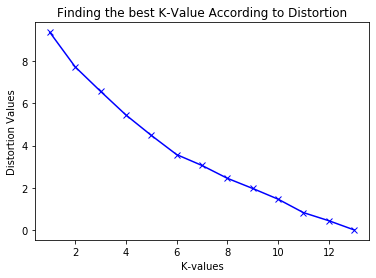

In [49]:
#observe the "elbowing" when distortion is plotted
K_values=range(1,14)
plt.plot(K_values, distortions, "bx-")
plt.xlabel("K-values")
plt.ylabel("Distortion Values")
plt.title("Finding the best K-Value According to Distortion")

Text(0.5, 1.0, 'Finding the best K-Value According to Inertia')

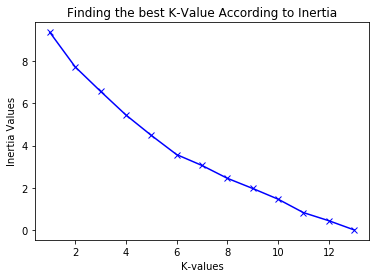

In [50]:
#observe the "elbowing" when inertia is plotted
K_values=range(1,14)
plt.plot(K_values, distortions, "bx-")
plt.xlabel("K-values")
plt.ylabel("Inertia Values")
plt.title("Finding the best K-Value According to Inertia")

***Alarming that there is no sharp bend in both distortion and inertia. This could only mean that the clustering is more spherical rather than elliptical in shape. It most likely means, some neighborhoods have more features than others, or some neighborhoods had less features than others. To be analyzed in the Discussion portion.***

Arbitrary, k-value of 8 is then chosen.

In [51]:
#8 clusters
kay=8
kmeans=KMeans(n_clusters=kay, random_state=0).fit(venues_standard_scaler)
kmeans.labels_[0:10]

array([1, 1, 5, 6, 2, 1, 3, 6, 6, 6])

Rank the occurence of venue category types of each neighborhood:

In [52]:
#order the common types of neighborhoods in neighborhood
#function for descending order
def ordered_venues(row, top_ten):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    return row_cat_sorted.index.values[0:top_ten]
#adding suffixes/ordinal names to the column ranking (1st, 2nd, 3rd, ..., etc.)
top_ten=10
col=['Neighborhood']
suffixes=['st', 'nd', 'rd']
for suff in np.arange(top_ten):
    try:
        col.append('{}{} Most Common Venue'.format(suff+1, suffixes[suff]))
    except:
        col.append('{}th Most Common Venue'.format(suff+1))
#lets start sorting in a new DataFrame
venues_sorted=pd.DataFrame(columns=col)
venues_sorted['Neighborhood']=venues_hot_mean['Neighborhood']
for i in np.arange(venues_hot_mean.shape[0]):
    venues_sorted.iloc[i, 1:]=ordered_venues(venues_hot_mean.iloc[i, :], top_ten)
venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BLUFF SPRINGS, Austin, TX, USA",Food,Bakery,Mexican Restaurant,Soccer Field,Pizza Place,Financial or Legal Service,Cycle Studio,Dance Studio,Deli / Bodega,Department Store
1,"CHERRY CREEK, Austin, TX, USA",Video Store,Food,Intersection,Mexican Restaurant,Yoga Studio,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
2,"DOWNTOWN, Austin, TX, USA",Hotel,Coffee Shop,Cocktail Bar,Gay Bar,Speakeasy,Steakhouse,Sushi Restaurant,American Restaurant,Bar,Lounge
3,"Dittmar Crossing, Austin, TX, USA",Print Shop,Food,Creperie,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dog Run,Donut Shop
4,"EAST CESAR CHAVEZ, Austin, TX, USA",Restaurant,Convenience Store,Music Venue,Liquor Store,Scenic Lookout,Karaoke Bar,Mexican Restaurant,Lake,Sporting Goods Shop,Pool


In [53]:
#combine the venues with the latitudes and longitudes
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
interested_df=zip_df
interested_df=zip_df.join(venues_sorted.set_index('Neighborhood'), on='Neighborhood')
interested_df.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Dittmar Crossing, Austin, TX, USA",30.183729,-97.813116,6,Print Shop,Food,Creperie,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dog Run,Donut Shop
1,"CHERRY CREEK, Austin, TX, USA",30.197113,-97.824812,1,Video Store,Food,Intersection,Mexican Restaurant,Yoga Studio,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
2,"SOUTH BRODIE, Austin, TX, USA",30.175622,-97.851637,6,Soccer Field,Trail,Dog Run,Yoga Studio,Financial or Legal Service,Creperie,Cycle Studio,Dance Studio,Deli / Bodega,Department Store
3,"SLAUGHTER CREEK, Austin, TX, USA",30.167554,-97.848329,6,Trail,Dog Run,Bus Stop,Yoga Studio,Food,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
4,"MCKINNEY, Austin, TX, USA",30.205876,-97.728015,6,Recreation Center,Gym,Theme Park,Yoga Studio,Financial or Legal Service,Creperie,Cycle Studio,Dance Studio,Deli / Bodega,Department Store


In [54]:
investment_clusters = folium.Map(location=[austin_lat, austin_long], zoom_start=11)
x = np.arange(kay)
ys = [i + x + (i*x)**2 for i in range(kay)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, long, neigh, cluster in zip(interested_df['Latitude'],interested_df['Longitude'], interested_df['Neighborhood'], interested_df['Cluster Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(investment_clusters)    
investment_clusters

**8. Finding the frequency of venue types**

  Find which venues have the highest frequency of occurence.

In [55]:
interested_df.columns

Index(['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [56]:
interested_df['1st Most Common Venue'].value_counts(normalize=True)

Hotel                  0.200000
Trail                  0.133333
Video Store            0.133333
Print Shop             0.066667
Restaurant             0.066667
Dog Run                0.066667
Soccer Field           0.066667
Food                   0.066667
IT Services            0.066667
American Restaurant    0.066667
Recreation Center      0.066667
Name: 1st Most Common Venue, dtype: float64

In [57]:
interested_df['2nd Most Common Venue'].value_counts(normalize=True)

Food                          0.200000
Coffee Shop                   0.133333
Dog Run                       0.133333
Financial or Legal Service    0.066667
Trail                         0.066667
Gym / Fitness Center          0.066667
Gym                           0.066667
Pool                          0.066667
Mexican Restaurant            0.066667
Bakery                        0.066667
Convenience Store             0.066667
Name: 2nd Most Common Venue, dtype: float64

In [58]:
interested_df['3rd Most Common Venue'].value_counts(normalize=True)

Bus Stop              0.133333
Cocktail Bar          0.133333
Intersection          0.133333
Creperie              0.066667
Dog Run               0.066667
Warehouse Store       0.066667
Bubble Tea Shop       0.066667
Yoga Studio           0.066667
Mexican Restaurant    0.066667
Hotel                 0.066667
Theme Park            0.066667
Music Venue           0.066667
Name: 3rd Most Common Venue, dtype: float64

In [59]:
interested_df['4th Most Common Venue'].value_counts(normalize=True)

Yoga Studio           0.266667
Mexican Restaurant    0.133333
French Restaurant     0.066667
Gym                   0.066667
Athletics & Sports    0.066667
Bar                   0.066667
Soccer Field          0.066667
Indian Restaurant     0.066667
Liquor Store          0.066667
Cycle Studio          0.066667
Gay Bar               0.066667
Name: 4th Most Common Venue, dtype: float64

In [60]:
interested_df['5th Most Common Venue'].value_counts(normalize=True)

Food                          0.200000
Financial or Legal Service    0.133333
Yoga Studio                   0.133333
New American Restaurant       0.066667
Scenic Lookout                0.066667
Speakeasy                     0.066667
Pizza Place                   0.066667
Cosmetics Shop                0.066667
Food Truck                    0.066667
Dance Studio                  0.066667
Steakhouse                    0.066667
Name: 5th Most Common Venue, dtype: float64

The most prominent venue types, in the order of most common are: hotels, food, cocktail bar (no one can really invest in an street intersection, unless I'm mistaken), yoga studio, and food venues again.

***These are the types of real estate that should be invested in the chosen locations.***

## IV. Results

   After finding out the which of the neighborhoods were nearest Big Tech companies, neighborhoods in the zip code area of 78759 and 78701 were chosen. The neighborhoods of interest are West-Over Hills, Gateway, Spicewood, UT Austin, Downtown Austin, West Austin, and East Cesar Chavez.
   
   After finding out which zip codes had the a high population and a positive population growth, neighborhoods in the zip code of 78748 and 78744 were chosen. The neighborhoods of interest are Dittmar Crossing, Cherry Creek, South Brodie, Slaughter Creek, McKinney, Bluff Springs, Onion Creek and Franklin Park.
   
   These venues were then found around these aforementioned neighborhoods, where venue category were used as features for K-mean clustering. K-means clustering returned no remarkable distinction. No underlying trend was found.
   
   Venue category was then ranked by frequency and the top most likely type of venue category/real estate were: hotels, food, cocktail bars, yoga studios and food venues.

## V.Discussion

   There were two dropped neighborhoods, Hays Wartha and Robinson Ranch. This was due to the OSM database not recognizing them. This could be a source of missing valuable data.
   
   Zip code 78759 and 78701 were chosen because they were in close proximity to Big Tech company clusters.
   
   Zip code 78748 and 78744 were chosen because they satisfied both conditions of being a high population size and a strong positive population growth.
   
   The elbow method in K-means clustering could mean that some neighborhoods had a high venue density, or some venues had a low venue density, or both. Although the K-means clustering was ultimately rejected, it does give a strong push to reassess which of these neighborhoods had a different feature density (venue density).
   
   It is proposed that the 78701 area is the reason for this smooth curve. This is important since the REIT company would avoid other neighborhoods with less features or less venues since there are less real estate opportunities to invest in.

## VI.Conclusion (Open-Ended)

   ***If building from this data analysis alone, one should build an REIT portfolio in neighborhoods in the zip code of 78759, 78701, 78748 and 78744. The real estate types that should be part of the portfolio should constitute real estate  involving hotels, food(perhaps restaurants), cocktail bars and yoga studios to maximize profit.***
   
   Although, the conclusion is left open-ended since, one could take better steps to take more precise and accurate data analytics. Here are some suggestions to get more desirable results:
   1. Instead of OSM database (Nominatim) for location data, Google API could be used. Unfortunately, this project had budget limitations. Google API is more up-to-date and may provide better location data.
   2. Population in 2020 is still being processed by the U.S. Census Beareau, but should be considered in analyzing population size and population growth trend once available.
   3. Instead of using zip codes, the U.S. census beareau offers something similar called ZTCA or Zip Code Tabulation Area which collates areas into a more standard zip code. Note ZTCA and zip code are not the same. Zip codes are issued by the USPS and not the U.S. Census Beareau. Zip code have more variation over time and change depending on the postal offices service needs.
   4. Look at other factors that may affect the success of different real estate types, such as average income and household types per neighborhood. Different habits and spending occur in different income levels and household needs. For example a single person household has different spending habits than a family household. That single person may choose to spend more income at bars and clubs and the family household may prefer spending in daycare and family resorts.
   5. Use different unsupervised machine learning algorithms to find hidden patterns in the data set.
   
   These are just some examples of how this project can be made better.